In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# Set color map to have light blue background
sns.set()

import scipy as sp
import scipy.stats as stats

import statsmodels.formula.api as smf
import statsmodels.api as sm

import sklearn.linear_model
import patsy

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# PROBLEM STATEMENT WITH HYPOTHOSIS 

A company has been seeing a fluctuation in employee retention and would like to understand if there are contributing factors that are highly corrilated to employee turnover, along with creating a modle that would be able to predict if there are conditions which would sugest that an employee has a high likelyhood of leaving.  

The manager believes attrition factors could include: satisfaction survey, evaluation, number of projects, hours worked, time with the company, accidents, permotions, salary, and department.

Since there is currently no known connection between each of the factors we can state the Null hypothosis {H_0} as being the event that satisfaction is not corrilated to employee turnover. Since this is a nullifiable statement we will suggest hypothosis {H_1} is situation where there is a corrilation between employee turnover and satisfaction. 

After evaluating a focused hypothosis we can then look at the connection between all of the factors and employee turnover.

# DATA SOURCE AND DESCRIPTION

The CSV data set for the question at hand was obtained form "kaggle": https://www.kaggle.com/gummulasrikanth/hr-employee-retention. 


### Data Fields
- satisfaction - Employee satisfaction level with 1 being highest
- last_evaluation - Last evaluation score (floating point represents percentage)
- number_project - Number of projects assigned to
- average_monthly_hour - Average monthly hours worked
- time_spend_company - Time spent at the company
- Work_accident - (1= Yes, 0 = No) - Whether they have had a work accident
- left - Whether or not employee left company (1 = Yes, 0 = No) 
- promotion_last_5year - (1 = Yes, 0 = No) - Whether they have had a promotion in the last 5 years
- sales - Department name (not just sales)
- salary - Salary category

In [2]:
# Read in the Human Resources DataSet found form the Kagle website
data = pd.read_csv("HR_comma_sep.csv")
#save series copy of data  
info = data

# load data into a DataFram to view raw data
df = pd.DataFrame(data)

## DESCRIPTION OF INDIVIDUAL FACTORS (outliers, possible needed transforms)

- ### Cleaning the data

In [3]:
# check to see if there is any missing data 
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


- ### Transforming the data

In [5]:
# viewing the data it looks like we have 14999 observations and 10 features
df.shape

(14999, 10)

In [6]:
# let take a look at the feature type
df.dtypes


satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [7]:
# It looks like sales and Salary are catigorical so let modify type. The other's look ok
df['sales'] = df.sales.astype("category")
df['salary'] = df.salary.astype("category")

In [8]:
# using a custom context matrix convert attrition evaluation to 0 or 1
#y,X = patsy.dmatrices("C(left,[[0],[1]]) ~  0 + satisfaction_level", data=df)
#print('y is ', y.shape, 'X is ', X.shape)

- ### Assessing outliers 

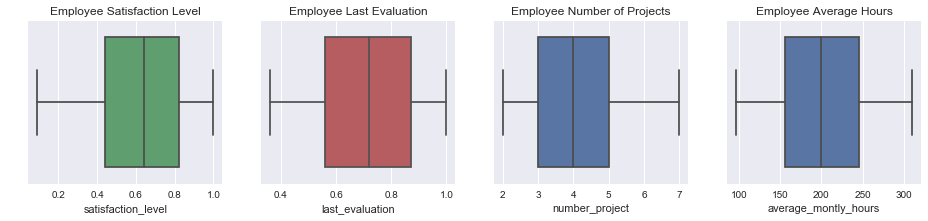

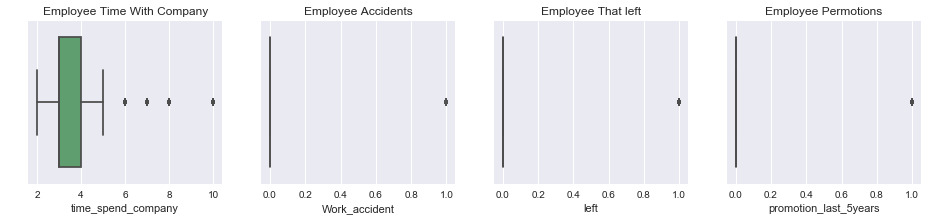

In [9]:
# Using boxplots we are able to clearly see outliers without loosing informaiton as in the 
# case with trying to use a histogram. Here we can clearly see that our bottom row holds 
# some outliers; however, "work accidents", "left", and "promitions" range between 0 and 1
# so we cannot take them out without ruining the integrity of the data. We can see time
# with the company has a few outliers "people that fall outside the 95% of the total mean population"
# knowing this we can save the indegrity of the information by finding those data points and removing 
# that employee informtion to make sure it does not through off the mean sensitive models.



# Set up the matplotlib figure top set
f, axes = plt.subplots(1,4, figsize=(16, 3))

# Graph Employee Satisfaction Level
sns.boxplot(df.satisfaction_level, color="g", ax=axes[0]).set_title('Employee Satisfaction Level')
axes[0].set_ylabel(' ');

# Graph Employee Last Evaluation
sns.boxplot(df.last_evaluation, color="r", ax=axes[1]).set_title('Employee Last Evaluation')
axes[1].set_ylabel(' ');

# Graph Employee Number of Projects
sns.boxplot(df.number_project, color="b", ax=axes[2]).set_title('Employee Number of Projects')
axes[2].set_ylabel(' ');

# Graph Employee Average Hours
sns.boxplot(df.average_montly_hours, color="b", ax=axes[3]).set_title('Employee Average Hours')
axes[3].set_ylabel(' ');

# Set up the matplotlib figure for second row
f, axes = plt.subplots(1,4, figsize=(16, 3))

# Graph Employee Time With Company
sns.boxplot(df.time_spend_company, color="g", ax=axes[0]).set_title('Employee Time With Company')
axes[0].set_ylabel(' ');

# Graph Employee Accidents
sns.boxplot(df.Work_accident, color="r", ax=axes[1]).set_title('Employee Accidents')
axes[1].set_ylabel(' ');

# Graph Employee That left
sns.boxplot(df.left, color="b", ax=axes[2]).set_title('Employee That left')
axes[2].set_ylabel(' ');

# Graph Employee Permotions
sns.boxplot(df.promotion_last_5years, color="b", ax=axes[3]).set_title('Employee Permotions')
axes[3].set_ylabel(' ');

In [10]:
# to take out the informtion we had found in our outlier lets first look at the total number of outliers
# since we have 14,000 entries I think we are still safe to drop
df.time_spend_company[df.time_spend_company >= 6].count()

1282

In [11]:
# lets drop the rows and check to make sure we still have the dataframe
df = df[df['time_spend_company'] < 6]
print(df.time_spend_company[df.time_spend_company >= 6].count())
print(df.shape)

0
(13717, 10)


## Deaper look into the data

In [12]:
# let's take a look into the total turnover ratio
# this gives us a snapshot look into where the company is since they had begun to collect the data 
attrition_ratio = df.left.sum() / len(df)
retention_ratio = 1 - attrition_ratio
print("Total Percent of employees that have stayed = ", "{0:.2f}%".format(retention_ratio * 100))
print("Total Percent of employees that have left = ", "{0:.2f}%".format(attrition_ratio * 100))

Total Percent of employees that have stayed =  75.49%
Total Percent of employees that have left =  24.51%


In [13]:
# lets look at the average observation (grouped by attrition). 
# since "sales, and salary" are catigorical they are not displayed here
# a few interesting things to point out is that satisfaction is much higher for those that are current
# and work accident's and promotions are higher for thoughs that are currently with the company
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.674539,0.716879,3.774119,199.079285,2.976437,0.172187,0.021342
1,0.418272,0.706511,3.810827,205.254313,3.744497,0.047293,0.005651


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


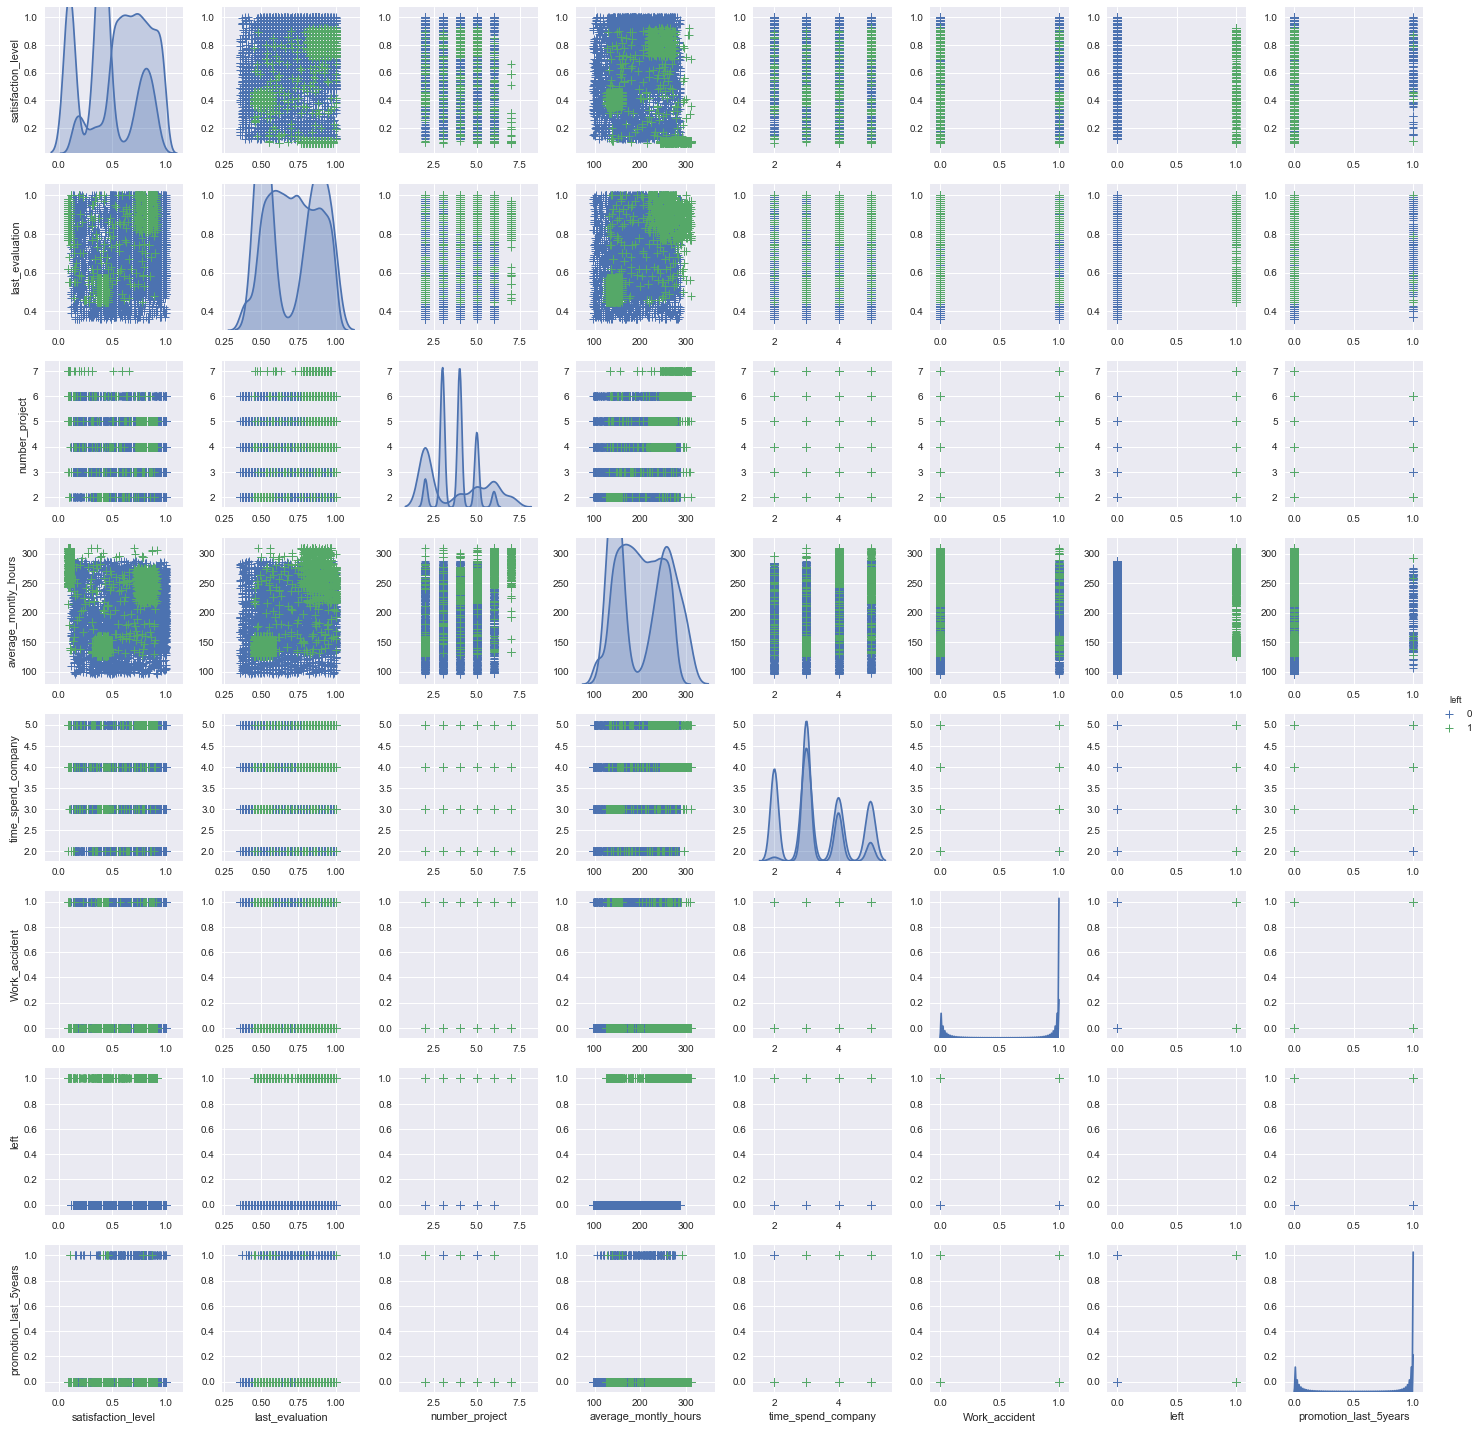

In [14]:
# from the pairplot we can see that there may be some expoential distibutons happening in the "accidents", and "permotions"
# other than that the distributions look to be non normal. 
# we can also start to see how the green markers (people that left the company) are grouping together which might 
# be showing us that the data might have some natureal classification lines. 
sns.pairplot(df, hue="left", markers="+", diag_kind="kde", plot_kws=dict(s=50, edgecolor="b", linewidth=1), diag_kws=dict(shade=True));

## ANALYSIS OF DATA DISTRIBUTION (what distibution does the data follow)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


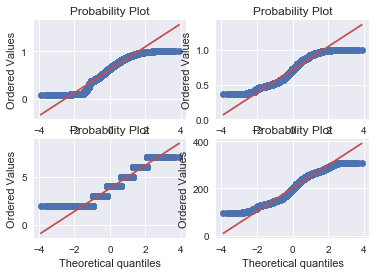

In [15]:
# as we can see from the prob plots that none of the attributes follow a normal distribution
# but it looks like projects and time spent at the company and permotion could follow an 
# exponential distribution
ax1 = plt.subplot(221)
res = stats.probplot(df.satisfaction_level, plot=plt)
ax2 = plt.subplot(222)
res = stats.probplot(df.last_evaluation, plot=plt)
ax3 = plt.subplot(223)
res = stats.probplot(df.number_project, plot=plt)
ax4 = plt.subplot(224)
res = stats.probplot(df.average_montly_hours, plot=plt)
ax5 = plt.subplot(224);


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


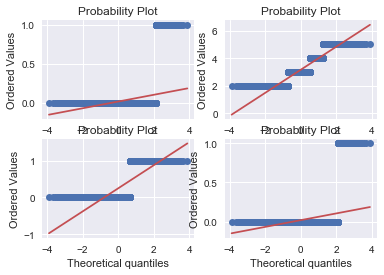

In [16]:
ax1 = plt.subplot(221)
res = stats.probplot(df.promotion_last_5years, plot=plt)
ax2 = plt.subplot(222)
res = stats.probplot(df.time_spend_company, plot=plt)
ax3 = plt.subplot(223)
res = stats.probplot(df.left, plot=plt)
ax4 = plt.subplot(224)
res = stats.probplot(df.promotion_last_5years, plot=plt)
ax5 = plt.subplot(224);

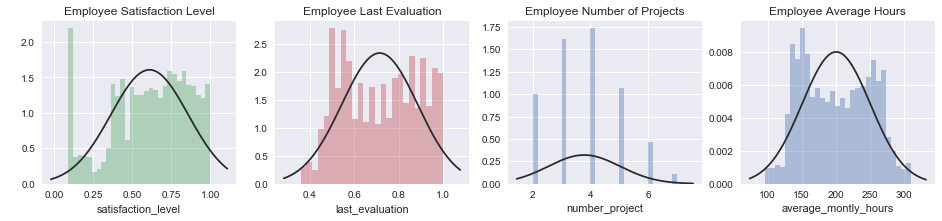

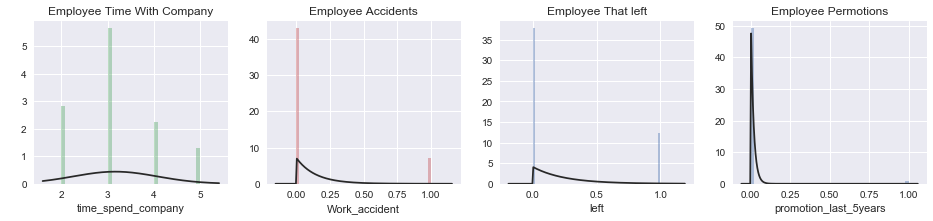

In [17]:
# looking at this data with a histagram and kde it looks like none of the features
# follow a distribution patter; however, it looks like the permotion looks like it
# is a good fit for the exponential distribution.

# Set up the matplotlib figure top set
f, axes = plt.subplots(1,4, figsize=(16, 3))

# Graph Employee Satisfaction Level
sns.distplot(df.satisfaction_level, color="g", kde=False, fit=stats.norm, ax=axes[0]).set_title('Employee Satisfaction Level')
axes[0].set_ylabel(' ');

# Graph Employee Last Evaluation
sns.distplot(df.last_evaluation, color="r", kde=False, fit=stats.norm, ax=axes[1]).set_title('Employee Last Evaluation')
axes[1].set_ylabel(' ');

# Graph Employee Number of Projects
sns.distplot(df.number_project, color="b", kde=False, fit=stats.norm, ax=axes[2]).set_title('Employee Number of Projects')
axes[2].set_ylabel(' ');

# Graph Employee Average Hours
sns.distplot(df.average_montly_hours, color="b", kde=False, fit=stats.norm, ax=axes[3]).set_title('Employee Average Hours')
axes[3].set_ylabel(' ');

# Set up the matplotlib figure for second row
f, axes = plt.subplots(1,4, figsize=(16, 3))

# Graph Employee Time With Company
sns.distplot(df.time_spend_company, color="g", kde=False, fit=stats.norm, ax=axes[0]).set_title('Employee Time With Company')
axes[0].set_ylabel(' ');

# Graph Employee Accidents
sns.distplot(df.Work_accident, color="r", kde=False, fit=stats.expon, ax=axes[1]).set_title('Employee Accidents')
axes[1].set_ylabel(' ');

# Graph Employee That left
sns.distplot(df.left, color="b", kde=False, fit=stats.expon, ax=axes[2]).set_title('Employee That left')
axes[2].set_ylabel(' ');

# Graph Employee Permotions
sns.distplot(df.promotion_last_5years, color="b", kde=False, fit=stats.expon, ax=axes[3]).set_title('Employee Permotions')
axes[3].set_ylabel(' ');

## ANALYSIS OF CORRELATION OR RELATIONSHIPS BETWEEN INDIVIDUAL FACTORS 

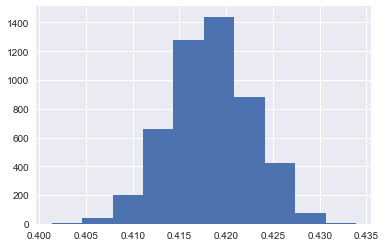

In [18]:
# using a Student-T distribution we can check the Null Hypothosis by testing weather the
# sample mean veries much form the population mean of the Null statement

# lets find the mean satisfaction level for both those those that left and stayed
#df.groupby(df['left'] == 0).satisfaction_level.mean()
working = df['satisfaction_level'][df['left'] == 0]
left = df['satisfaction_level'][df['left'] == 1]

Test_m = np.mean(left)

# test 5000 samples of df.satisfaction_level 
n = 5000

# using CLT we show x and y such that 95% of the probability mass falls between x and y

# A list of 1000 randomly E[x] for satisfaction level of those that left to make it normally distirbuted
sample_left = ( [ np.mean( np.random.choice(left, len(left)) ) for x in range(n) ] )
plt.hist(sample_left);

left_m = np.mean(sample_left)
left_v = np.var(sample_left)
left_n = len(sample_left)
left_se = np.sqrt(left_v / left_n)

Upper CI = 0.418207839364 Median = 0.4182718619869114 Lower CI= 0.418450341481


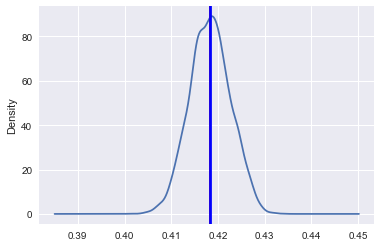

In [19]:
# printing out the convidence interval from the 95% T-test we 
# can see that we must reject the Null Hypothosis  
# This leads us to believe that there is a connection
# between people leaving and satisfaction levels

l_ci = []

# 1: t-distrabution value
t_crit = stats.t(len(sample_left) - 1).ppf((1-.95)/2)

# 1 + 2: get upper and lower bound of t-distrabution form sample
lower = left_m  - t_crit * left_se 
upper = t_crit * left_se + left_m

l_ci.append(upper)
l_ci.append(left_m)
l_ci.append(lower)

print("Upper CI =", upper, "Median =", Test_m, "Lower CI=",lower)

sample_left = pd.Series(sample_left)

sample_left.plot.kde();
plt.axvline(x=Test_m,color='red');
plt.axvline(x=l_ci[0],color='blue');
plt.axvline(x=l_ci[2],color='blue');



In [20]:
# function to to update corrilated funcitons list 
def forward_stepwise(regressed_on, cf, remaining):
    column = ''
    score = 0.0
    current_score = 0.0
    
    for i in remaining:
        current_score = smf.ols('{} ~ {} + 1'.format(regressed_on, ' + '.join(cf + [i])), data=train_df).fit().rsquared_adj

        if current_score > score:
            column = i 
            score = current_score
    
    return column


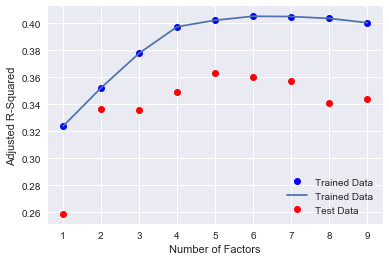

In [21]:
# use the previously aquared M_0 to evaluate against
# remainig factors for best R^2

# sample 200 random samples as training samples
train_df = df.loc[np.random.choice(df.index, 200), :]

# sample 200 for test for fair evaluation that is not overly optomistic
test_df = df.loc[np.random.choice(df.index, 200), :]

R_squred = []
Test_R2 = []
factors = []
remaining = set(df.columns)
remaining.remove('left')

for _ in range (9):
    M_x = forward_stepwise('left', factors, remaining)

    # save factors evaluated agains M_0 in list
    factors.append(M_x)


    formula = '{} ~ {} + 1'.format('left', ' + '.join(factors))
    train = smf.ols(formula, data=train_df).fit().rsquared_adj
    test = smf.ols(formula, data=test_df).fit().rsquared_adj

    # update r_squared list 
    R_squred.append(train)
    Test_R2.append(test)

    # update remaining factors list
    remaining.remove(M_x)


num_factor = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots()
plt.plot(num_factor, R_squred, 'bo', c='blue', label='Trained Data');
plt.plot(num_factor, R_squred, label='Trained Data');
plt.plot(num_factor, Test_R2,'bo', c='red', label='Test Data');


ax.set_xlabel('Number of Factors')
ax.set_ylabel('Adjusted R-Squared')

plt.legend()
plt.show()

In [28]:
# looking at our trained and test data it looks like it peaked at 5 factors 
# so we can select the first 5 of our list and display the R-squared information

print(factors)
formula = 'left ~ satisfaction_level + time_spend_company + number_project + salary + Work_accident'
est = smf.ols(formula, data=df).fit()
est.summary().tables[0]

['satisfaction_level', 'time_spend_company', 'number_project', 'salary', 'Work_accident', 'promotion_last_5years', 'average_montly_hours', 'sales', 'last_evaluation']


Dep. Variable:,left,R-squared:,0.316
Model:,OLS,Adj. R-squared:,0.316
Method:,Least Squares,F-statistic:,1055.
Date:,"Sat, 11 Aug 2018",Prob (F-statistic):,0.00
Time:,03:45:43,Log-Likelihood:,-5287.1
No. Observations:,13717,AIC:,1.059e+04
Df Residuals:,13710,BIC:,1.064e+04
Df Model:,6,,
Covariance Type:,nonrobust,,


## SUMMARY

After review of the data it looks like not only are we going to reject the null hypothosis but we will also found the factors that make the best model fit for the data. Even thought this is interesting there are still a few more questions that would be worth exploring to ensure the analysis is leading to a full answer: 
- Is there a time component to satisfaction levels?  this could reveal a seasonal, management, or other influences to the factor.
- All of the features are assumed to be independed, however, could be a connection between average monthy hours worked and evaluation?